This notebook will be performing below steps :
1. Loading the base model
2. setting up  LORA config
3. Data prep for finetuning.
4. Setting up the hyperparameters, training args and kick off the training.
5. Saving the LORA adapters post training.
6. Merging the LORA adapter with pretrained model and save locally.
7. Merging the LORA adapter with pretrained model and push to huggingface's repo.

8. Calling the model from higgingface's repo and answer the question.

**Step 1** - Installing unsloth

In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

**Step 2** - loading model from unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None # None for auto detection.
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

four_bit_models = [

                   "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
]


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,


)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.12: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

**Step 3** - Setup LORA adapters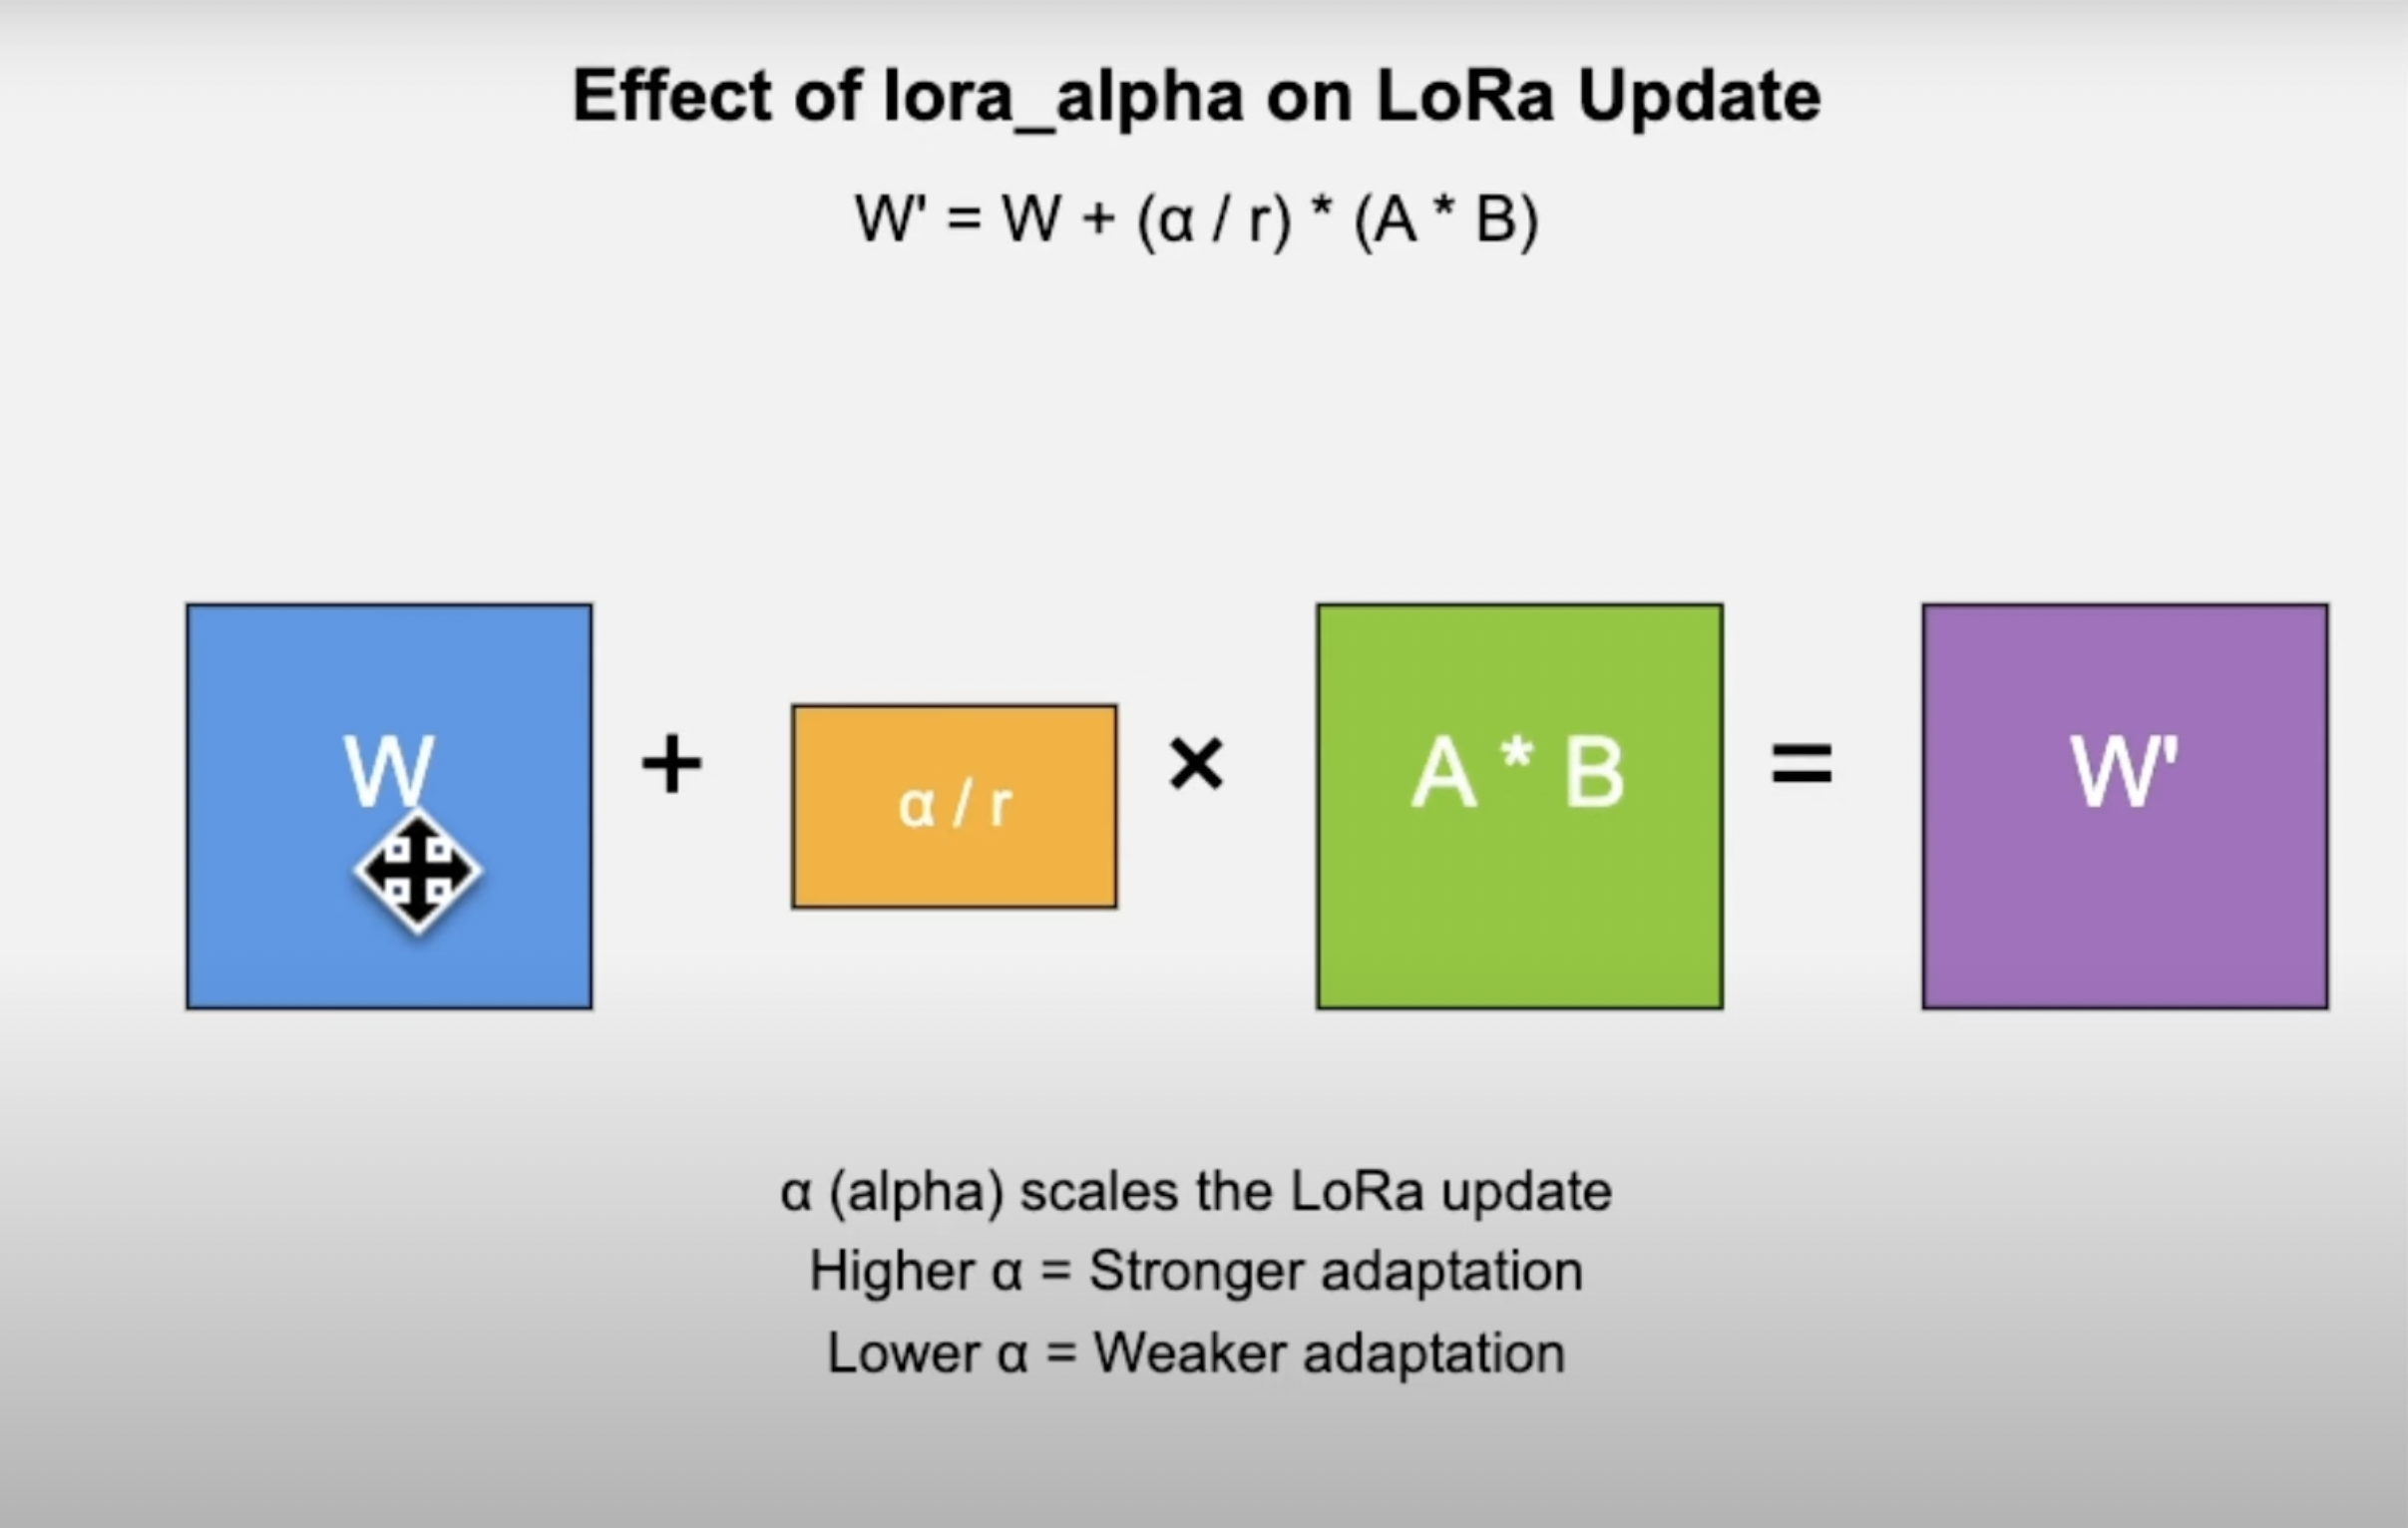

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,#this is rank of the matrices used at adapter layer , higher the rank (could be 8, 16, 32,64, 128) means higher the parameters , that would consume more resources.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj" ,"gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16, #this tells how much contribution these lora adapters are going to have of the final weights of the model. i.e. weaker values = lower adaptation, higher values = strong adaptation.
    lora_dropout = 0,
    bias = "none" ,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,

)

Unsloth 2024.12.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


**Step 4** - Data Prep

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/51760 [00:00<?, ? examples/s]

**Train 5** - Model Training - we will use huggingface's TRL package. (i.e. SFTTrainer)

In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)


Map (num_proc=2):   0%|          | 0/51760 [00:00<?, ? examples/s]

In [6]:
#check memory stats


gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.004 GB of memory reserved.


In [7]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 51,760 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.586800
2,2.115200
3,1.672900
4,1.863200
5,1.678900
6,1.490300
7,1.081100
8,1.269800
9,1.144200
10,1.122600


TrainOutput(global_step=60, training_loss=1.0465037912130355, metrics={'train_runtime': 501.0516, 'train_samples_per_second': 0.958, 'train_steps_per_second': 0.12, 'total_flos': 5726714157219840.0, 'train_loss': 1.0465037912130355, 'epoch': 0.00927357032457496})

**Loading , saving the model**
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [9]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

**Inference** - You can also use a TextStreamer for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

Now if you want to load the LoRA adapters we just saved for inference, set False to True:

In [10]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

==((====))==  Unsloth 2024.12.12: Fast Llama patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is a famous tall tower in Paris?

### Input:


### Response:
The Eiffel Tower is a famous tall tower in Paris, France. It is a landmark of the city and is one of the most recognizable structures in the world. The tower was built in 1889 for the Exposition Universelle, and it was the tallest man-made structure in the world at the time. The Eiffe

**Save the model locally**

In [13]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

In [15]:
# Merge to 16bit
if True: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.5 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


  0%|          | 0/32 [00:00<?, ?it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [04:41<00:00,  8.79s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model-00001-of-00004.bin...
Unsloth: Saving model/pytorch_model-00002-of-00004.bin...
Unsloth: Saving model/pytorch_model-00003-of-00004.bin...
Unsloth: Saving model/pytorch_model-00004-of-00004.bin...
Done.


**# Push the merged model to Hugging Face Hub**

In [16]:
if True:
    model.push_to_hub_merged(
        "your_user_name/Llama3.1_8B_finetuned",  # Replace with your Hugging Face username and desired repo name
        tokenizer,
        save_method="merged_16bit",
        token=""  # Replace with your actual Hugging Face token
    )

Unsloth: You are pushing to hub, but you passed your HF username = nelish007.
We shall truncate nelish007/Llama3.1_8B_finetuned to Llama3.1_8B_finetuned


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.63 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [04:56<00:00,  9.25s/it]


Unsloth: Saving tokenizer...

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Done.
Unsloth: Saving Llama3.1_8B_finetuned/pytorch_model-00001-of-00004.bin...
Unsloth: Saving Llama3.1_8B_finetuned/pytorch_model-00002-of-00004.bin...
Unsloth: Saving Llama3.1_8B_finetuned/pytorch_model-00003-of-00004.bin...
Unsloth: Saving Llama3.1_8B_finetuned/pytorch_model-00004-of-00004.bin...


README.md:   0%|          | 0.00/590 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/nelish007/Llama3.1_8B_finetuned


**Testing the model's output directly from Huggingface**

In [17]:
!pip install transformers torch


When you load a model from the Hugging Face Hub for the first time in a session, it downloads all necessary files, including the model weights, configuration, and tokenizer. This can take some time, especially for large models. However, once the model is loaded into memory, you can use it to answer multiple questions without reloading the files.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "nelish007/Llama3.1_8B_finetuned"  # Replace with your model's path
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
question = "What is a famous tall tower in Paris?"
inputs = tokenizer(question, return_tensors="pt").to("cuda")  # Use "cuda" if you have a GPU
outputs = model.generate(**inputs, max_new_tokens=50)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)